Using device: cuda


Epoch 1/5: 100%|██████████| 1151/1151 [03:05<00:00,  6.19it/s]


Epoch 1/5 | Train Loss: 0.6567 | Val Loss: 0.6746 | Val Acc: 0.5665


Epoch 2/5: 100%|██████████| 1151/1151 [03:39<00:00,  5.24it/s]


Epoch 2/5 | Train Loss: 0.6408 | Val Loss: 0.6629 | Val Acc: 0.5899


Epoch 3/5: 100%|██████████| 1151/1151 [03:29<00:00,  5.50it/s]


Epoch 3/5 | Train Loss: 0.6268 | Val Loss: 0.6568 | Val Acc: 0.6046


Epoch 4/5: 100%|██████████| 1151/1151 [03:30<00:00,  5.47it/s]


Epoch 4/5 | Train Loss: 0.6136 | Val Loss: 0.6406 | Val Acc: 0.6297


Epoch 5/5: 100%|██████████| 1151/1151 [03:38<00:00,  5.27it/s]


Epoch 5/5 | Train Loss: 0.6024 | Val Loss: 0.6363 | Val Acc: 0.6325

Classification Metrics:
    Accuracy  Precision    Recall  F1-Score
0  0.632468   0.654482  0.491503  0.561404


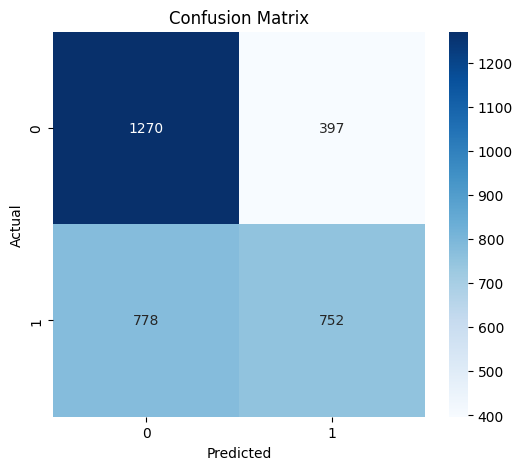

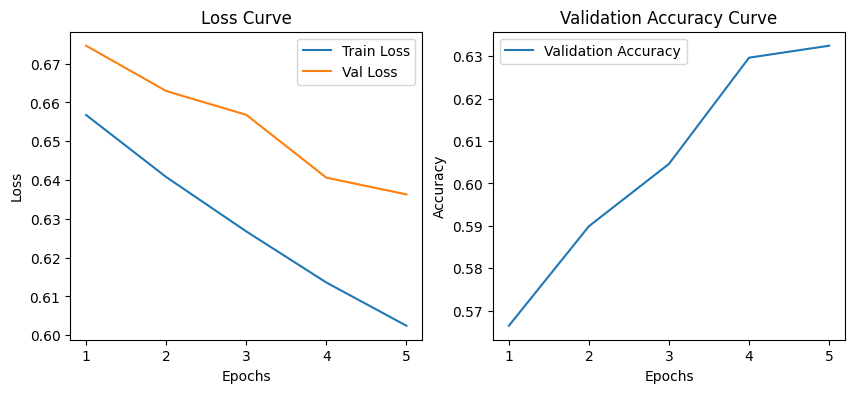

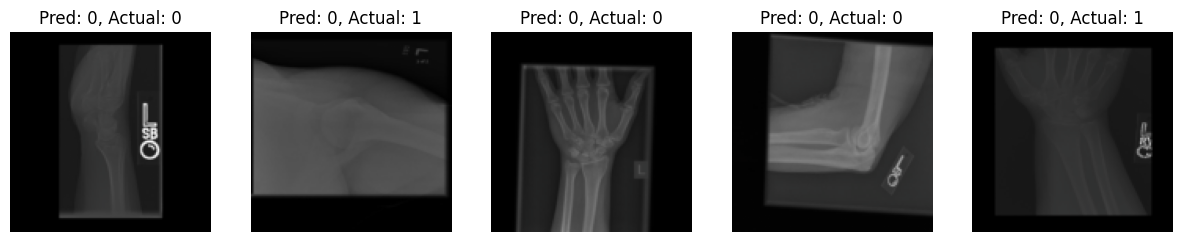

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# -----------------------------
# Step 1: Device Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Step 2: Dataset Class
# -----------------------------
class MURADataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0].replace("\\", "/")
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# -----------------------------
# Step 3: Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -----------------------------
# Step 4: Load Data
# -----------------------------
train_dataset = MURADataset(r"Datasets\MURA-v1.1\train_complete_path_images.csv", transform=train_transform)
valid_dataset = MURADataset(r"Datasets\MURA-v1.1\valid_complete_path_images.csv", transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# -----------------------------
# Step 5: Simple CNN Model
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# -----------------------------
# Step 6: Training Loop
# -----------------------------
num_epochs = 5
train_losses, val_losses, val_accs = [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    y_true, y_pred = [], []
    val_loss = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).int()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    val_loss = val_loss / len(valid_loader)
    val_losses.append(val_loss)
    acc = accuracy_score(y_true, y_pred)
    val_accs.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")

# -----------------------------
# Step 7: Classification Metrics Table
# -----------------------------
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [precision],
    "Recall": [recall],
    "F1-Score": [f1]
})
print("\nClassification Metrics:\n", metrics_df)

# -----------------------------
# Step 8: Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# Step 9: Loss & Accuracy Graph
# -----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1), val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Curve")
plt.show()

# -----------------------------
# Step 10: Test Some Images
# -----------------------------
test_dataset = MURADataset(r"Datasets\MURA-v1.1\valid_complete_path_images.csv", transform=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
preds = (outputs > 0.5).int()

# Display images with predictions
plt.figure(figsize=(15,5))
for i in range(len(images)):
    img = images[i].cpu().permute(1,2,0)  # C,H,W to H,W,C
    img = img * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])  # unnormalize
    img = img.numpy()
    plt.subplot(1,len(images),i+1)
    plt.imshow(img)
    plt.title(f"Pred: {preds[i].item()}, Actual: {labels[i].item()}")
    plt.axis("off")
plt.show()
